# Retina MNIST notebook

## import libraries

In [229]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
tf.get_logger().setLevel('ERROR')

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

In [230]:
# !pip install --upgrade h5py

## Import the dataset

In [231]:
!pip install medmnist

In [232]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import random as rd
from tensorflow.keras.utils import to_categorical


In [233]:
def download_and_prepare_dataset(data_info: dict):
    """Utility function to download the dataset.

    Arguments:
        data_info (dict): Dataset metadata.
    """
    data_path = tf.keras.utils.get_file(origin=data_info["url"],fname='retinamnist', md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        # Get videos
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        # Get labels
        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels),
    )


# Get the metadata of the dataset
info = medmnist.INFO["retinamnist"]
# info = medmnist.INFO["retinamnist"]


# Get the dataset
prepared_dataset = download_and_prepare_dataset(info)
(x_train, y_train) = prepared_dataset[0]
(x_val, y_val) = prepared_dataset[1]
(x_test, y_test) = prepared_dataset[2]

In [234]:
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical

x_train = x_train/255
x_test = x_test/255

# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
train_images = np.expand_dims(x_train, -1)
test_images = np.expand_dims(x_test, -1)

# Flatten the images to 2D arrays for PCA
train_images_flat = train_images.reshape(train_images.shape[0], -1)  # Shape: (num_samples, 28*28)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Initialize PCA to keep 8 components
pca = PCA(n_components=6)

# Fit PCA on the training images and transform the datasets
train_images = pca.fit_transform(train_images_flat)
test_images = pca.transform(test_images_flat)

# Map the labels 3 -> 0 and 6 -> 1
y_train = np.where(y_train == 0, 0, 1)
y_test = np.where(y_test == 0, 0, 1)

# One-hot encode the labels
train_labels = to_categorical(y_train, 2)
test_labels = to_categorical(y_test, 2)

# Print the shapes of the processed datasets
print("Shape of train images after PCA:", train_labels.shape)
print("Shape of test images after PCA:", test_labels.shape)
print("Shape of train labels:", train_labels.shape)
print("Shape of test labels:", test_labels.shape)


Shape of train images after PCA: (1080, 2)
Shape of test images after PCA: (400, 2)
Shape of train labels: (1080, 2)
Shape of test labels: (400, 2)


In [235]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")

Unique labels in the training set: [0 1]


In [236]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

##  Quantum functions

In [237]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# qOrthNN + Dynamic Dropout

In [279]:
class HybridModel(tf.keras.Model):
    def __init__(self,apply_quantum_dropout):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten(name='flatten')
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64, name='dense_classical')
        self.quantum_weights2 = self.add_weight(
            shape=(15,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32,
            name='quantum_weights2'
        )
        self.theta_locked = self.add_weight(
            shape=(15,),
            initializer='zeros',
            trainable=False,
            dtype=tf.float32,
            name='theta_locked'
        )

        self.dev = qml.device('default.qubit.tf', wires=6)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64, name='dense_output')

        # Droppout mask
        self.theta_wire_0 = tf.constant([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=tf.int32)
        self.theta_wire_1 = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=tf.int32)
        # self.theta_wire_1 = tf.constant([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], dtype=tf.int32)
        # Only Drop 1 Qubit or 1 Wire
        self.n_drop = tf.constant(1, dtype=tf.int32)

        self.drop_flag = tf.Variable(apply_quantum_dropout, trainable=False)


    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights2)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )

        # Apply the condition using tf.cond
        quantum_outputs = tf.cond(
            self.drop_flag,
            lambda: tf.concat([
                tf.zeros((tf.shape(quantum_outputs)[0], 1), dtype=tf.float64),  # Create a tensor of zeros
                quantum_outputs[:, 1:]  # Keep the rest of the elements
            ], axis=1),
            lambda: quantum_outputs  # Keep original quantum_outputs if drop_flag is False
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    def train_step(self, data):
        x, y = data  # Unpack the data

        # Lock the dropped gates
        self.theta_locked = tf.identity(self.quantum_weights2)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Find the index of self.quantum_weights2 in self.trainable_variables
        quantum_weight_index = None
        for idx, var in enumerate(self.trainable_variables):
            if var is self.quantum_weights2:
                quantum_weight_index = idx
                break

        # Ensure the index was found
        if quantum_weight_index is None:
            raise ValueError("self.quantum_weights2 not found in trainable_variables")

        # Prepare the mask for the gradients
        # Create a zero mask with the same shape as theta_wire_0
        theta_mask = tf.zeros_like(self.theta_wire_0, dtype=tf.int32)

        # Update the mask based on drop_flag and n_drop
        # If drop_flag is True and n_drop == 1, use theta_wire_0 as the mask
        theta_mask = tf.where(
            tf.logical_and(tf.equal(self.n_drop, 1), self.drop_flag),
            self.theta_wire_0,
            theta_mask
        )

        # If drop_flag is True and n_drop == 2, use theta_wire_0 + theta_wire_1 as the mask
        theta_mask = tf.where(
            tf.logical_and(tf.equal(self.n_drop, 2), self.drop_flag),
            self.theta_wire_0 + self.theta_wire_1,
            theta_mask
        )

        # Ensure mask is binary (0 or 1)
        theta_mask = tf.where(theta_mask >= 1, tf.ones_like(theta_mask), tf.zeros_like(theta_mask))

        # Cast mask to match gradient data type
        theta_mask = tf.cast(theta_mask, gradients[quantum_weight_index].dtype)

        # Reshape theta_mask to match the shape of gradients[quantum_weight_index]
        theta_mask = tf.reshape(theta_mask, tf.shape(gradients[quantum_weight_index]))

        # Apply the mask to the gradient
        quantum_masked_gradients = gradients[quantum_weight_index] * (1 - theta_mask)

        # Update the gradient in sanitized_gradients
        sanitized_gradients[quantum_weight_index] = quantum_masked_gradients

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        # Handle NaN values in trainable variables
        for var in self.trainable_variables:
            nan_mask = tf.math.is_nan(var)
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            var.assign(sanitized_var)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}



In [280]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        # Get the optimizer
        optimizer = self.model.optimizer

        # Get the current training step (number of iterations)
        current_step = tf.keras.backend.get_value(optimizer.iterations)

        # Evaluate the learning rate schedule at the current step
        current_lr = optimizer.learning_rate(current_step)

        # Convert the learning rate tensor to a float value
        current_lr_value = tf.keras.backend.get_value(current_lr)

        # Store the learning rate for the next iteration
        self.new_lr = current_lr_value

        # Optionally, print or log the learning rate
        print(f"Epoch {epoch + 1}: Learning Rate is {self.new_lr}")


# Validation with Dropout



In [281]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf


all_train_auc = []  # List to store training AUC for plotting
all_val_auc = []  # List to store validation AUC for plotting
all_losses = []  # For training loss
all_val_losses = []  # For validation loss
all_train_acc = []  # For training accuracy
all_val_acc = []  # For validation accuracy
seeds = []

for random in [100]:
    if os.path.exists('quantum_weights.weights.h5'):
        os.remove('quantum_weights.weights.h5')
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    initial_lr = 0.3
    seed_losses = []
    seed_val_losses = []
    seed_train_acc = []
    seed_val_acc = []
    seed_train_auc = []  # List to store training AUC for each epoch
    seed_val_auc = []  # List to store validation AUC for each epoch

    for iteration in range(1, 5):
        print(f"Epochs {iteration}")

        # Switch dropout flag randomly
        if rd.random() <= 0.5 and iteration != 1:
            drop_flag = True
            print("Applying Quantum Dropout")
        else:
            drop_flag = False
            print("Not Applying Quantum Dropout")

        # Create the model
        model = HybridModel(apply_quantum_dropout=drop_flag)
        initial_learning_rate = initial_lr
        final_learning_rate = 0.03

        # Define your custom learning rate schedule
        class CustomLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __init__(self, initial_lr, final_lr, decay_steps):
                super(CustomLearningRateSchedule, self).__init__()
                self.initial_lr = initial_lr
                self.final_lr = final_lr
                self.decay_steps = decay_steps

            def __call__(self, step):
                pi = tf.constant(math.pi, dtype=tf.float32)
                step = tf.cast(step, tf.float32)
                decay_steps = tf.cast(self.decay_steps, tf.float32)
                cosine_decay = 0.5 * (1 + tf.cos(pi * step / decay_steps))
                decayed = (1 - self.final_lr / self.initial_lr) * cosine_decay + (self.final_lr / self.initial_lr)
                return self.initial_lr * decayed

        # Instantiate the learning rate schedule
        initial_lr = 0.01
        final_lr = 0.001
        decay_steps = 1000

        learning_rate_schedule = CustomLearningRateSchedule(initial_lr, final_lr, decay_steps)

        # Use the learning rate schedule in your optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

        # Compile your model with the optimizer
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','AUC'])


        lr_logger = LearningRateLogger()

        # Train the model with the callback
        history = model.fit(
            train_images, train_labels,
            epochs=1,
            batch_size=32,
            verbose=1,
            validation_data=(test_images, test_labels),
            callbacks=[lr_logger]
        )

        # Update the learning rate for the next iteration
        if lr_logger.new_lr:
            initial_lr = lr_logger.new_lr

        # Store losses and metrics for this iteration
        seed_losses.append(history.history['loss'][0])
        seed_val_losses.append(history.history['val_loss'][0])
        seed_train_acc.append(history.history['accuracy'][0])
        seed_val_acc.append(history.history['val_accuracy'][0])
        seed_train_auc.append(history.history['auc'][0])  # Add training AUC value
        seed_val_auc.append(history.history['val_auc'][0])  # Add validation AUC value

        # Save the weights after training
        import os
        if os.path.exists('quantum_weights.weights.h5'):
            os.remove('quantum_weights.weights.h5')
        model.save_weights('quantum_weights.weights.h5')


    # Store the metrics for the seed
    seeds.append(random)
    all_losses.append(seed_losses)
    all_val_losses.append(seed_val_losses)
    all_train_acc.append(seed_train_acc)
    all_val_acc.append(seed_val_acc)
    all_train_auc.append(seed_train_auc)  # Store training AUC
    all_val_auc.append(seed_val_auc)  # Store validation AUC




Training with random seed: 100
Epochs 1
Not Applying Quantum Dropout
34/34 [==============================] - 22s 297ms/step - loss: 0.6844 - accuracy: 0.6259 - auc: 0.6379 - val_loss: 0.6526 - val_accuracy: 0.6475 - val_auc: 0.6578
Epochs 2
Applying Quantum Dropout
34/34 [==============================] - 21s 292ms/step - loss: 0.7074 - accuracy: 0.5296 - auc: 0.5388 - val_loss: 0.6743 - val_accuracy: 0.5725 - val_auc: 0.5779
Epochs 3
Not Applying Quantum Dropout
34/34 [==============================] - 25s 292ms/step - loss: 0.6617 - accuracy: 0.6056 - auc: 0.6298 - val_loss: 0.6011 - val_accuracy: 0.7150 - val_auc: 0.7384
Epochs 4
Not Applying Quantum Dropout
34/34 [==============================] - 21s 278ms/step - loss: 0.7187 - accuracy: 0.5417 - auc: 0.5321 - val_loss: 0.6734 - val_accuracy: 0.5750 - val_auc: 0.5555


In [282]:
# !pip install --upgrade scipy h5py


# Validation without Technique

In [243]:
import random as rd
class HybridModel(tf.keras.Model):
    def __init__(self,random1):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        rd.seed(random1)
        np.random.seed(random1)
        tf.random.set_seed(random1)
        qml.numpy.random.seed(random1)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit.tf', wires=6)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

In [244]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

no_train_auc = []  # List to store training AUC for plotting
no_val_auc = []  # List to store validation AUC for plotting
no_losses = []  # For training loss
no_val_losses = []  # For validation loss
no_train_acc = []  # For training accuracy
no_val_acc = []  # For validation accuracy
seeds = []
epoch = 4
for random in [100]:
    if os.path.exists('quantum_weights.weights.h5'):
        os.remove('quantum_weights.weights.h5')
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    initial_lr = 0.3

    # Create the model
    model = HybridModel(random)
    initial_learning_rate = initial_lr
    final_learning_rate = 0.03

    # Define learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=16,
        alpha=final_learning_rate / initial_learning_rate
    )

    # Adam optimizer with the cosine scheduler
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
    )

    lr_logger = LearningRateLogger()

    # Train the model with the callback
    history = model.fit(
        train_images, train_labels,
        epochs=epoch,
        batch_size=32,
        verbose=1,
        validation_data=(test_images, test_labels)
    )



    # Store losses and metrics for this iteration
    no_losses.append(history.history['loss'])
    no_val_losses.append(history.history['val_loss'])
    no_train_acc.append(history.history['accuracy'])
    no_val_acc.append(history.history['val_accuracy'])
    no_train_auc.append(history.history['auc'])  # Add training AUC value
    no_val_auc.append(history.history['val_auc'])  # Add validation AUC value





Training with random seed: 100
Epoch 1/4
34/34 [==============================] - 24s 279ms/step - loss: 0.6908 - accuracy: 0.5954 - auc: 0.6092 - val_loss: 0.6336 - val_accuracy: 0.6525 - val_auc: 0.7039
Epoch 2/4
34/34 [==============================] - 6s 188ms/step - loss: 0.6240 - accuracy: 0.6713 - auc: 0.7153 - val_loss: 0.6033 - val_accuracy: 0.6800 - val_auc: 0.7384
Epoch 3/4
34/34 [==============================] - 6s 186ms/step - loss: 0.5876 - accuracy: 0.7074 - auc: 0.7584 - val_loss: 0.6018 - val_accuracy: 0.6850 - val_auc: 0.7388
Epoch 4/4
34/34 [==============================] - 6s 185ms/step - loss: 0.5768 - accuracy: 0.7046 - auc: 0.7682 - val_loss: 0.6316 - val_accuracy: 0.6725 - val_auc: 0.6994


# Validation with Pruning

In [245]:
class HybridModel(tf.keras.Model):
    def __init__(self,random1):
        super(HybridModel, self).__init__()
        # rd.seed(random1)
        # np.random.seed(random1)
        # tf.random.set_seed(random1)
        # qml.numpy.random.seed(random1)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer="random_normal",
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit.tf', wires=6)
        # Pruning attributes
        self.accumulated_grads = tf.Variable(tf.zeros_like(self.quantum_weights), trainable=False)
        self.accumulate_flag = tf.Variable(True, trainable=False)
        
        self.accumulate_window = tf.constant(7)
        self.prune_window = tf.constant(6)
        self.prune_ratio = tf.Variable(0.0, trainable=False)
        
        self.accumulate_count = tf.Variable(7, dtype=tf.int32, trainable=False)
        self.prune_count = tf.Variable(6, dtype=tf.int32, trainable=False)


        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    
    @tf.function
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Initialize placeholders
        grad_qw = None
        other_gradients = []
        other_variables = []

        # Separate gradients for quantum_weights and other variables
        for grad, var in zip(gradients, self.trainable_variables):
            if var is self.quantum_weights:
                grad_qw = grad
            else:
                if grad is not None:
                    other_gradients.append(grad)
                    other_variables.append(var)

        # Switch flag for PGP
        def switch_flag():
            if self.accumulate_count == 0:
                self.accumulate_count.assign(self.accumulate_window)
                self.accumulate_flag.assign(False)
            elif self.prune_count == 0:
                self.prune_count.assign(self.prune_window)
                self.accumulate_flag.assign(True)
        switch_flag()
        
        # Probabilistic Gradient Pruning
        if tf.equal(self.accumulate_flag, True):
            # Accumulate gradients for quantum_weights
            self.accumulate_count.assign_sub(1)
            if grad_qw is not None:
                self.accumulated_grads.assign_add(tf.cast(grad_qw, tf.float32))

            # Apply gradients for other variables
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))
        else:
            # Prune weights of quantum_weights
            self.prune_count.assign_sub(1)
            # Normalize the accumulated gradients
            grad_min = tf.reduce_min(self.accumulated_grads)
            grad_max = tf.reduce_max(self.accumulated_grads)
            epsilon = 1e-8
            norm_grads = (self.accumulated_grads - grad_min) / (grad_max - grad_min + epsilon)

            # Add epsilon to norm_grads to avoid log(0)
            norm_grads_with_epsilon = norm_grads + epsilon

            # Compute logits for categorical sampling
            logits = tf.math.log(norm_grads_with_epsilon)

            # Determine the number of parameters to sample
            num_params = self.quantum_weights.shape[0]
            num_samples = int(self.prune_ratio * num_params)
            num_samples = tf.maximum(1, num_samples)  # Ensure at least one parameter is sampled

            # Sample indices based on the normalized gradients
            indices = tf.random.categorical([logits], num_samples=num_samples)
            indices = tf.clip_by_value(indices, 0, self.quantum_weights.shape[0] - 1)  # Ensure indices are within range

            # Create a boolean mask to select the parameters to keep
            mask = tf.zeros_like(self.quantum_weights, dtype=tf.bool)
            indices = tf.cast(indices, tf.int32)
            indices = tf.reshape(indices, [-1, 1])  # Ensure indices are shaped correctly
            updates = tf.ones([tf.shape(indices)[0]], dtype=tf.bool)  # Create updates matching the indices length

            mask = tf.tensor_scatter_nd_update(mask, indices, updates)

            # Apply the mask to the accumulated gradients
            pruned_grad = tf.where(mask, self.accumulated_grads, tf.zeros_like(self.accumulated_grads))

            # Apply the pruned gradient to quantum_weights
            self.optimizer.apply_gradients([(pruned_grad, self.quantum_weights)])

            # Apply gradients for other variables
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))

            # Reset accumulator
            self.accumulated_grads.assign(tf.zeros_like(self.accumulated_grads))

        # Sanitize weights: replace NaNs with zeros
        for var in self.trainable_variables:
            nan_mask = tf.math.is_nan(var)
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            var.assign(sanitized_var)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

SP_train_auc = []  # List to store training AUC for plotting
SP_val_auc = []  # List to store validation AUC for plotting
SP_losses = []  # For training loss
SP_val_losses = []  # For validation loss
SP_train_acc = []  # For training accuracy
SP_val_acc = []  # For validation accuracy
seeds = []
epoch = 4

for random in [100]:

    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    initial_lr = 0.3

    # Create the model
    model = HybridModel(random)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',   # Metric to monitor
        patience=3,           # Number of epochs with no improvement after which training will be stopped
        min_delta=0.01,      # Minimum change to qualify as an improvement
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
    )
    initial_learning_rate = initial_lr
    final_learning_rate = 0.003

    # Define learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=16,
        alpha=final_learning_rate / initial_learning_rate
    )

    # Adam optimizer with the cosine scheduler
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','AUC'])

    # Train the model and store the validation accuracy
    history = model.fit(
        train_images, train_labels,
        epochs=4,
        batch_size=8,
        validation_data=(test_images, test_labels),
        verbose=1,
        callbacks=[early_stopping]  # Include the EarlyStopping callback
    )


    # Store losses and metrics for this iteration
    SP_losses.append(history.history['loss'])
    SP_val_losses.append(history.history['val_loss'])
    SP_train_acc.append(history.history['accuracy'])
    SP_val_acc.append(history.history['val_accuracy'])
    SP_train_auc.append(history.history['auc'])  # Add training AUC value
    SP_val_auc.append(history.history['val_auc'])  # Add validation AUC value


Training with random seed: 100
Epoch 1/4
135/135 [==============================] - 23s 78ms/step - loss: 0.6597 - accuracy: 0.6361 - auc: 0.6690 - val_loss: 0.6226 - val_accuracy: 0.6725 - val_auc: 0.7112
Epoch 2/4
135/135 [==============================] - 7s 55ms/step - loss: 0.6146 - accuracy: 0.6898 - auc: 0.7237 - val_loss: 0.5957 - val_accuracy: 0.6850 - val_auc: 0.7466
Epoch 3/4
135/135 [==============================] - 8s 56ms/step - loss: 0.6037 - accuracy: 0.7000 - auc: 0.7388 - val_loss: 0.5847 - val_accuracy: 0.7075 - val_auc: 0.7579
Epoch 4/4
135/135 [==============================] - 8s 56ms/step - loss: 0.5947 - accuracy: 0.7074 - auc: 0.7508 - val_loss: 0.5761 - val_accuracy: 0.7150 - val_auc: 0.7682


# Plot the Validation 

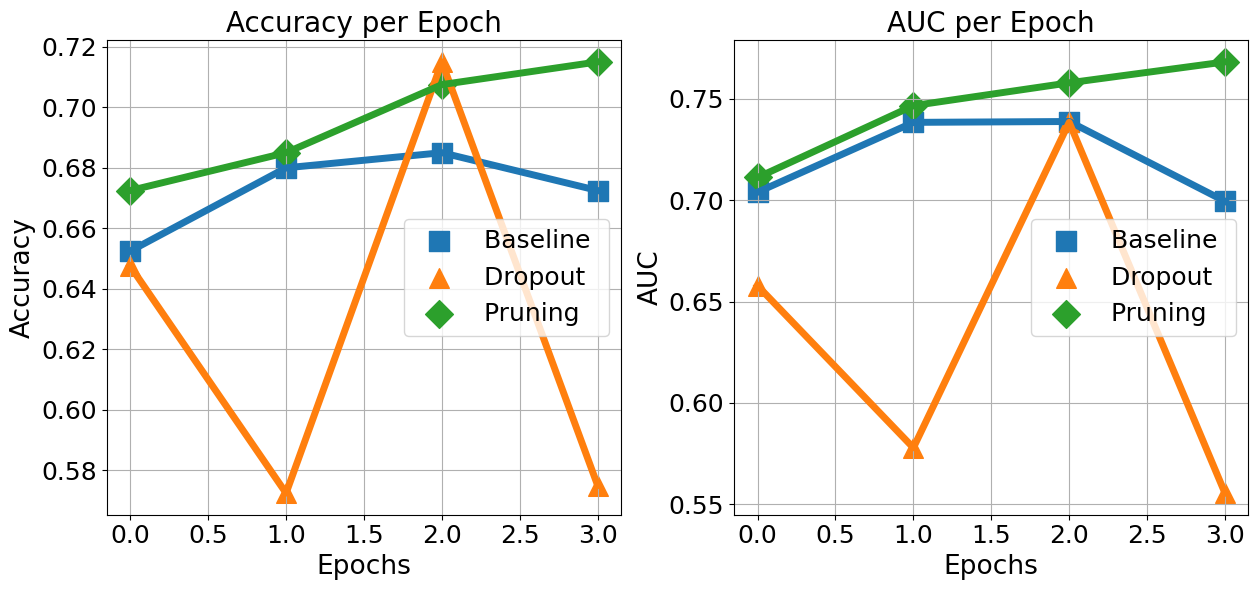

In [ ]:
# Ensure all metrics are flattened to 1D arrays
no_losses = np.ravel(no_losses)
no_val_losses = np.ravel(no_val_losses)
no_train_acc = np.ravel(no_train_acc)
no_val_acc = np.ravel(no_val_acc)
no_train_auc = np.ravel(no_train_auc)
no_val_auc = np.ravel(no_val_auc)

all_losses = np.ravel(all_losses)
all_val_losses = np.ravel(all_val_losses)
all_train_acc = np.ravel(all_train_acc)
all_val_acc = np.ravel(all_val_acc)
all_train_auc = np.ravel(all_train_auc)
all_val_auc = np.ravel(all_val_auc)

SP_losses = np.ravel(SP_losses)
SP_val_losses = np.ravel(SP_val_losses)
SP_train_acc = np.ravel(SP_train_acc)
SP_val_acc = np.ravel(SP_val_acc)
SP_train_auc = np.ravel(SP_train_auc)
SP_val_auc = np.ravel(SP_val_auc)

# Define the number of epochs (ensure consistent length)
epochs = range(len(no_losses))

# Set up the plot figure size
plt.figure(figsize=(18, 6))

# Define font size for elements
title_fontsize = 20
label_fontsize = 19
legend_fontsize = 18
tick_fontsize = 18
line_width = 5  # Line width
marker_size = 200  # Marker size

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs, no_val_acc, linestyle='-', linewidth=line_width)  # Baseline line
plt.scatter(epochs, no_val_acc, marker='s', s=marker_size, label='Baseline ')  # Square marker for Baseline
plt.plot(epochs, all_val_acc, linestyle='-', linewidth=line_width)  # Dropout line
plt.scatter(epochs, all_val_acc, marker='^', s=marker_size, label='Dropout ')  # Triangle marker for Dropout
plt.plot(epochs, SP_val_acc, linestyle='-', linewidth=line_width)  # SP line
plt.scatter(epochs, SP_val_acc, marker='D', s=marker_size, label='Pruning ')  # Diamond marker for SP
plt.title('Accuracy per Epoch', fontsize=title_fontsize)
plt.xlabel('Epochs', fontsize=label_fontsize)
plt.ylabel('Accuracy', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid()

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(epochs, no_val_auc, linestyle='-', linewidth=line_width)  # Baseline line
plt.scatter(epochs, no_val_auc, marker='s', s=marker_size, label='Baseline ')  # Square marker for Baseline
plt.plot(epochs, all_val_auc, linestyle='-', linewidth=line_width)  # Dropout line
plt.scatter(epochs, all_val_auc, marker='^', s=marker_size, label='Dropout ')  # Triangle marker for Dropout
plt.plot(epochs, SP_val_auc, linestyle='-', linewidth=line_width)  # SP line
plt.scatter(epochs, SP_val_auc, marker='D', s=marker_size, label='Pruning ')  # Diamond marker for SP
plt.title('AUC per Epoch', fontsize=title_fontsize)
plt.xlabel('Epochs', fontsize=label_fontsize)
plt.ylabel('AUC', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid()

plt.tight_layout()
# plt.show()
plt.savefig("retina_graph.pdf")
